Restart runtime after every pip install

## Set-up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install nltk==3.4 --quiet
!pip install pyldavis --quiet

     |████████████████████████████████| 1.4 MB 5.2 MB/s 
     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.7 MB 178 kB/s 
     |████████████████████████████████| 11.3 MB 41.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.2 which is incompatible.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from wordcloud import WordCloud
sns.set_style('whitegrid')

# Import NLP libraries
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Import LDA libraries
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/releas

In [69]:
path = '/content/drive/Shareddrives/CMPE295-TeamEquality/RQAR Code/2. Data Cleaning/data/train_QA_pair.csv'
df_QA_train = pd.read_csv(path)
df_QA = df_QA_train.drop(columns=['comment_id','comment_upvotes','suggested_subreddits']).drop_duplicates()
df_QA

,question_id,question,question_vocab
0,eib8be,Looking for a subreddit about redundancy (sort of),looking redundancy sort place good idealess work cost effective environmentally friendly actually complete opposite maybe redundant wrong word given task almost thought joke perhaps information done ate time slow day 1l bottle motor oil ## l can hold unscrewing cap bottle unscrew switch put back box ### l couple picture
1,eibax6,ideas for playing/teaching toddlers,idea teaching toddler 3 year old brother always play run thing also trying teach talking conversation
4,eibcq9,I need a subreddit where I can ask legal questions regarding tech startups and strartups in general,need legal question regarding tech general one example would use term condition put company name
7,eibg1f,Is there a subreddit for ragequits? Bonus if it’s fighting game exclusive.,bonus fighting game exclusive
9,eibpte,Is there a subreddit to help me find a particular book if I remember a very general detail from said book?,particular book remember general detail said scene story previously read cant put finger actually maybe could really main character foreign city gravel pebble made gold silver inhabitant common dirt ground would u course see quite attempt stuff pocket full one acting sort guide make passing remark along line men always fascinated stone wonder particularly avid reader likely school might necessarily wondering there place get good brain coming
...,...,...,...
80537,o0na8i,A sub to answer my questions about customizing jackets,answer question jacket looking forward getting embroidery painting dying fabric mainly leather jacket thing unclear specific solid could forum cannot think
80545,o0o8q8,"A sub for creative writing, lyrics, poetry?",creative writing lyric poetry
80547,o0oakk,A subreddit to make actual online friends?,make actual friend title
80549,o0ox9h,What sub for questions about terms and conditions,question term condition video make directed different family member explaining plan going detail horrible thing sure rule calling cause taken first thought r legal advice issue


## 1. LDA Topic modeling

Use Mallet LDA for better result

Source: 
* Official LDA documents: https://radimrehurek.com/gensim/models/ldamodel.html
* Official LDA Mallet documents: https://radimrehurek.com/gensim_3.8.3/models/wrappers/ldamallet.html
* Topic Modeling Source Code: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
* LDA Mallet Implementation: https://medium.com/swlh/topic-modeling-lda-mallet-implementation-in-python-part-2-602ffb38d396

In [12]:
# source: https://medium.com/analytics-vidhya/mallet-machine-learning-for-language-toolkit-installation-on-google-colaboratory-80b75fe486cb
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


In [13]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2021-09-11 23:40:33--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  14.8MB/s    in 1.0s    

2021-09-11 23:40:34 (14.8 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [14]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8' 

### Word Preprocessing

In [93]:
def word_preprocess(df, vocab_col=str):
  
  # 1. Vocab preprocessing
  df_lda = df[vocab_col].tolist()
  df_lda_words = list(df_lda)

  stop_words = stopwords.words('english')
  stop_words.extend(['subreddit', 'subreddits', 'reddit', 'sub', 'nan']) # Remove reddit related words
  stop_words.extend(['question','like', 'post', 'find', 'finding', 'help', 'want', 'look', 'ask', 'people', 'something', 'thing', 'community', 'talk']) # Remove helper words
  stop_words.extend(['http', 'com', 'ww']) # Remove link

  df_lda_words = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in df_lda_words]
  df_id2word = corpora.Dictionary(df_lda_words)

  # 2. Term document frequency
  df_corpus = [df_id2word.doc2bow(word) for word in df_lda_words]

  return df_corpus, df_id2word, df_lda_words

In [169]:
df_QA_corpus, df_QA_id2word, df_QA_words = word_preprocess(df_QA, 'question_vocab')

Save dictionary for inference

In [99]:
lda_dictionary_path = "/content/drive/Shareddrives/CMPE295-TeamEquality/RQAR Code/2. Data Cleaning/LDA file/lda_dictionary.txt"
df_QA_id2word.save_as_text(lda_dictionary_path)
# loaded_dct = corpora.Dictionary.load_from_text(lda_dictionary_path)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


### Find best number of topics

* Coherence Score - how good a single topic is by measurin the degree of semantic similarity between high scoring words in the topic, the higher the better
* Help distinguish if topic is interpretable for humans

source: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [170]:
def compute_coherence_values(model, dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values= []
    model_list = []
    for num_topics in range(start, limit, step):
        if model == "mallet":
          mallet_path = '/content/mallet-2.0.8/bin/mallet'
          lda_model = gensim.models.wrappers.LdaMallet(mallet_path, 
                                        corpus=corpus, 
                                        id2word=dictionary,
                                        num_topics=num_topics)
        else:
          lda_model = gensim.models.LdaMulticore(corpus = corpus,
                                          id2word = dictionary,
                                          num_topics = num_topics,
                                          random_state = 41)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

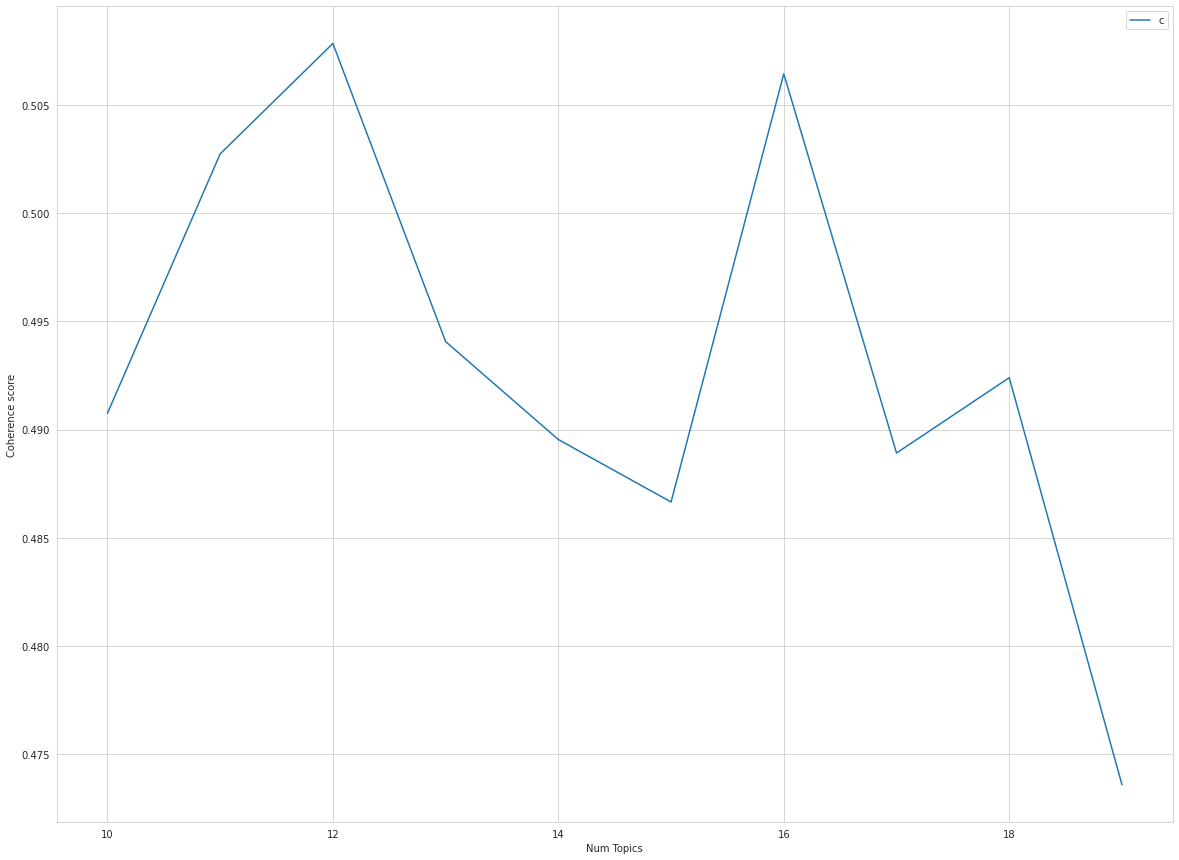

In [174]:
# Coherence Scores for Mallet LDA
limit=20; start=10; step=1;
model_list, coherence_values = compute_coherence_values(model = "mallet",
                                                        dictionary=df_QA_id2word, 
                                                        corpus=df_QA_corpus, 
                                                        texts=df_QA_words, 
                                                        start=start, limit=limit, step=step)

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

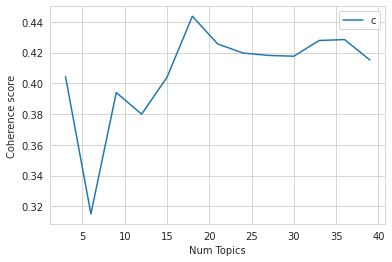

In [ ]:
# Coherence Scores for Regular LDA
model_list, coherence_values = compute_coherence_values(dictionary=df_QA_id2word, 
                                                        corpus=df_QA_corpus, 
                                                        texts=df_QA_words, 
                                                        start=start, limit=limit, step=step)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Build LDA Model
Pick best number of topics with highest coherence before flattening out

In [133]:
def create_lda_model(df, num_topics, df_corpus, df_id2word): 

  # 1. Define LDA model
  mallet_path = '/content/mallet-2.0.8/bin/mallet'
  lda_model = gensim.models.wrappers.LdaMallet(mallet_path, 
                                          corpus=df_corpus, 
                                          id2word=df_id2word,
                                          num_topics=num_topics)
  
  # 2. Extract topic modeling result
  tm_results = lda_model[df_corpus]
  corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]
  topic_list = [i[0] for i in corpus_topics] # Take topic with highest score
  topic_score = [i[1] for i in corpus_topics] # Take topic with highest score

  # 3. Add topic information to dataframe
  new_df = df.copy()
  new_df['LDA_Topic'] = topic_list
  new_df['LDA_Score'] = topic_score

  topic_vocab = {}
  for n in range(0, num_topics):
    vocabs = ''
    for term, wt in lda_model.show_topic(n, topn=5): # Consider only top 5 words to represent the topics
      vocabs += ' ' + term
    topic_vocab[n] = vocabs
  new_df["LDA_Vocab"] = new_df["LDA_Topic"].apply(lambda x: topic_vocab.get(x))

  return new_df, lda_model

In [175]:
# Iterate to get highest coherence score
max_score = 0.54
for i in range(25):
  df_QA_lda, QA_lda_model = create_lda_model(df_QA, 12, df_QA_corpus, df_QA_id2word)
  coherencemodel = CoherenceModel(model=QA_lda_model, texts=df_QA_words, dictionary=df_QA_id2word, coherence='c_v')
  score = coherencemodel.get_coherence()
  print(score)
  if max_score < score:
    max_score = score
    break

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.5112891915372435


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.5195382107289613


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.5180602485052247


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.5224001811671454


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.48240490294697663


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.5082392323934859


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.5142389775271222


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.5244487614101586


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.5049318338898805


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.4704621340482067


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.4915817602516501


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.4962730512573055


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.5006645926951777


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.4943246063535068


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.5126416901364369


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.5161415724596643


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.4974901294315277


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.5072796232666653


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.5086878524604999


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.505426448834853


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.5016420424610638


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.4998177482672106


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.4869949361740015


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.5105414850478572


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

0.4968033307231327


Save best lda model for inference

In [140]:
QA_lda_model.save("/content/drive/Shareddrives/CMPE295-TeamEquality/RQAR Code/2. Data Cleaning/LDA file/lda_model.model")

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [141]:
# Show all topics
pd.set_option('display.max_colwidth', -1)
topics = [[(term, round(wt, 3)) for term, wt in QA_lda_model.show_topic(n, topn=20)] for n in range(0, QA_lda_model.num_topics)]
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, QA_lda_model.num_topics+1)] )
topics_df

,Terms per Topic
Topic1,"discus, opinion, point, answer, wrong, discussion, topic, social, medium, removed, political, change, conversation, hate, fact, politics, side, reason, view, matter"
Topic2,"good, basically, stuff, guy, recently, made, pretty, related, whats, bit, high, bad, big, hey, person, thinking, guess, found, small, curious"
Topic3,"video, game, remember, show, movie, title, describe, play, character, search, description, watch, ago, link, detail, forgot, channel, theory, bunch, gaming"
Topic4,"time, lot, day, dont, food, hard, long, nice, couple, care, back, week, money, feel, taking, recipe, start, guy, literally, weight"
Topic5,"idea, make, art, artist, home, place, work, house, request, free, part, small, design, room, good, drawing, pay, building, made, space"
Topic6,"problem, car, phone, account, put, fix, call, open, hand, number, end, figure, turn, hour, answer, night, area, case, reason, doesnt"
Topic7,"work, tip, job, advice, learn, information, computer, school, working, start, related, learning, college, business, company, skill, offer, source, career, helpful"
Topic8,"year, friend, family, life, parent, ago, lost, month, child, member, live, living, covid, told, back, past, dad, adult, didnt, due"
Topic9,"place, make, dont, love, person, id, world, friend, girl, great, advance, country, talking, making, helping, good, hope, sense, happy, send"
Topic10,"similar, song, specific, music, suggestion, give, based, kind, recommendation, type, sound, suggest, title, fit, general, specifically, recommend, list, exist, interest"


#### Examples

In [150]:
# Look at question belonging to topic 7 (music related)
df_QA_lda[df_QA_lda['LDA_Topic'] == 6].sort_values(['LDA_Score'], ascending=[False])[:10]

,question_id,question,question_vocab,LDA_topic,LDA_Vocab
0,eib8be,Looking for a subreddit about redundancy (sort of),looking redundancy sort place good idealess work cost effective environmentally friendly actually complete opposite maybe redundant wrong word given task almost thought joke perhaps information done ate time slow day 1l bottle motor oil ## l can hold unscrewing cap bottle unscrew switch put back box ### l couple picture,6,work tip job advice learn
4,eibcq9,I need a subreddit where I can ask legal questions regarding tech startups and strartups in general,need legal question regarding tech general one example would use term condition put company name,6,work tip job advice learn
35,eic5hj,Is there a subreddit for computer experts or technicians?,computer expert technician got blue screen death went solution none worked someone problem thanks,6,work tip job advice learn
98,eieape,"Is there a fitness type reddit? Anything where people can talk about/get advice on exercise, dieting, etc?",fitness type anything get advice exercise,6,work tip job advice learn
138,eihmth,"Subreddit to expand my mind in the aspect of knowledge, skills and talents this year.",expand mind aspect knowledge skill talent year basically learn lot make productive good habit sub found useful r productivity book,6,work tip job advice learn
...,...,...,...,...,...
80394,nzmb2l,"Subreddit for discussing IT applications like Microsoft apps, Slack, SAP systems, etc?",application slack sap system best use certain task application discus update area,6,work tip job advice learn
80438,nzxikx,Any subreddit to get suggestions for methods to reduce noise from outside?,get suggestion method reduce noise outside,6,work tip job advice learn
80484,o0aati,A sub that helps you find/ suggests ways to make money with the information/skills/situation you provide,help way make money information skill situation provide title say looking tell detail exact talent resource hand suggest,6,work tip job advice learn
80503,o0d02b,subreddit for pharmacy students in the Philippines,pharmacy student none anything general thank advance,6,work tip job advice learn


In [152]:
# Look at question belonging to topic 9 (game related)
df_QA_lda[df_QA_lda['LDA_Topic'] == 8].sort_values(['LDA_Score'], ascending=[False])[:10]

,question_id,question,question_vocab,LDA_topic,LDA_Vocab
9,eibpte,Is there a subreddit to help me find a particular book if I remember a very general detail from said book?,particular book remember general detail said scene story previously read cant put finger actually maybe could really main character foreign city gravel pebble made gold silver inhabitant common dirt ground would u course see quite attempt stuff pocket full one acting sort guide make passing remark along line men always fascinated stone wonder particularly avid reader likely school might necessarily wondering there place get good brain coming,8,place make dont love person
47,eicwr8,Is there a rant subreddit for things you’re happy about?,rant thing happy,8,place make dont love person
58,eidlic,Online dating reddit?,dating nothing long term ya know chit chat thing,8,place make dont love person
145,eihw9j,"Looking for a subreddit that gives a true, raw look into poverty in third world countries.",looking give true raw poverty third world country place share photo experience maybe beautifully human moment,8,place make dont love person
172,eiikf7,Is there a subreddit that collects funny Donald Trump moments?,collect funny trump moment,8,place make dont love person
...,...,...,...,...,...
80289,nyveg4,A subreddit for people who are considering moving to another country,considering moving another country let say move would chat gain insight process document one,8,place make dont love person
80355,nzbx0i,"Who makes the most money and who gets the best benefits? City Police, County Sheriff, or State Troopers?",make money get best benefit city police county sheriff state trooper,8,place make dont love person
80358,nzd7xb,Is there a subreddit for talking about unsolved or solved online mysteries?,talking unsolved mystery really interest almost place seen tal ti either ended never able even post document better new advance,8,place make dont love person
80389,nzk4cr,"Currently, I am a 27M looking for my soulmate as I do not believe in making GF instead of marriage. Where could I find her?",currently ## m looking believe making instead marriage could true relationship work single men would mind telling impress girl meet world lack really generous getting tired,8,place make dont love person


In [ ]:
# Look at question with a high score in belonging to a topic
df_QA_lda.sort_values(['LDA_Topic', 'LDA_Score'], ascending=[True, False])

,question_id,question,question_vocab,comment_id,comment_upvotes,suggested_subreddits,LDA_topic,LDA_topic_score,LDA_Vocab
14160,ely7t6,"Finding the ultimate ""Buy it for Life"" Over the ear Headphones",finding ultimate buy life ear headphone please let know searching possibly long time think requirement keep electronics simple able last tech smart wondering someone suggest purchase endless page different kind going mad envision lasting wired via cord avoid problem road battery failing issue simply degrading normal wear tear use would also prevent possible damage micro port actual set plug auxiliary cable get replacement soldering work note ideally microphone phone call built sound decently one ## cad returned due removable otherwise alright model number ### however exactly anyone suggestion would greatly appreciate thanks,fdl19zj,1,r/buyitforlife,0,0.266284,"[buy, item, product, phone, information]"
13759,i9fygj,A sub for getting information for exporting to USA,getting information need export organic soap textile product first time read book import dummy micro manufacturer shop ### piece worth ### looking know process instance much value good send mail entry duty assessed export qualify,g38td28,1,r/distributor,0,0.223684,"[buy, item, product, phone, information]"
16282,krqcpb,Is there a reddit to ask/find a product?,product one earring gifted lost clue would possibly buy new replacement able example 2 brother randomly shoe concert could picture maybe someone pair sell u got idea saw chick posted another lady exact size girl sent anything similar,gib9q8j,2,r/helpmefind,0,0.216134,"[buy, item, product, phone, information]"
29073,l8lmea,A sub-reddit for tech advice,tech advice need get apple retail store clue specifically wondering could mail device apple ' device r technology individual concern,gld80l7,1,r/applehelp,0,0.211966,"[buy, item, product, phone, information]"
12056,glqgzs,Any reddit for people who can give advice on import/export trading restrictions ?,give advice import export trading restriction got know reliable supplier surgical mask canada sure duty fee selling,fqzfaco,1,r/legaladvice,0,0.208333,"[buy, item, product, phone, information]"
...,...,...,...,...,...,...,...,...,...
5192,gc0x0z,Where can I find this subreddit?,would someone place ## s ## s,fp8vz9i,1,r/askreddit,14,0.074074,"[thing, stuff, make, kind, place]"
6628,he5lww,A sub it promote new subs,promote new sub,fvplals,2,r/newreddits,14,0.074074,"[thing, stuff, make, kind, place]"
19442,hode8x,Is there a subreddit opposite of r /RoastMe?,opposite r,fxh3mbp,2,r/toastme,14,0.074074,"[thing, stuff, make, kind, place]"
8578,hg8z4z,A place for souisidal people,place,fw2fm6y,1,r/suicidewatch,14,0.074074,"[thing, stuff, make, kind, place]"


In [ ]:
# Save dataframe with LDA topic
df_QA_lda = df_QA_train.merge(df_QA_lda, how='inner', on='question_id')
df_QA_lda = df_QA_lda[['question_id', 'question_x', 'question_vocab_x', 'comment_id', 'comment_upvotes', 'suggested_subreddits', 'LDA_Vocab']]
df_QA_lda = df_QA_lda.rename(columns={ 
                      "question_x": "question",
                      "question_vocab_x": "question_vocab"})
path = '/content/drive/Shareddrives/CMPE295-TeamEquality/RQAR Code/2. Data Cleaning/data/train_QA_with_topic.csv'
df_QA_lda.to_csv(path, index=False)

## 2. EDA

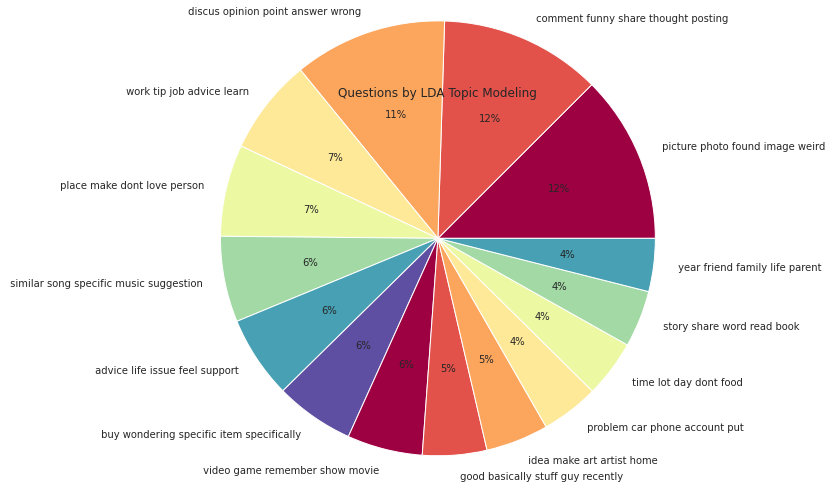

In [165]:
# Report historically answered questions by question topic
plt.figure(figsize=(15,5), edgecolor='b')
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]
df_QA_lda['LDA_Vocab'].value_counts().plot(kind="pie", radius=2.0, autopct='%1.0f%%', colors=colors)
plt.title('Questions by LDA Topic Modeling')
plt.show()

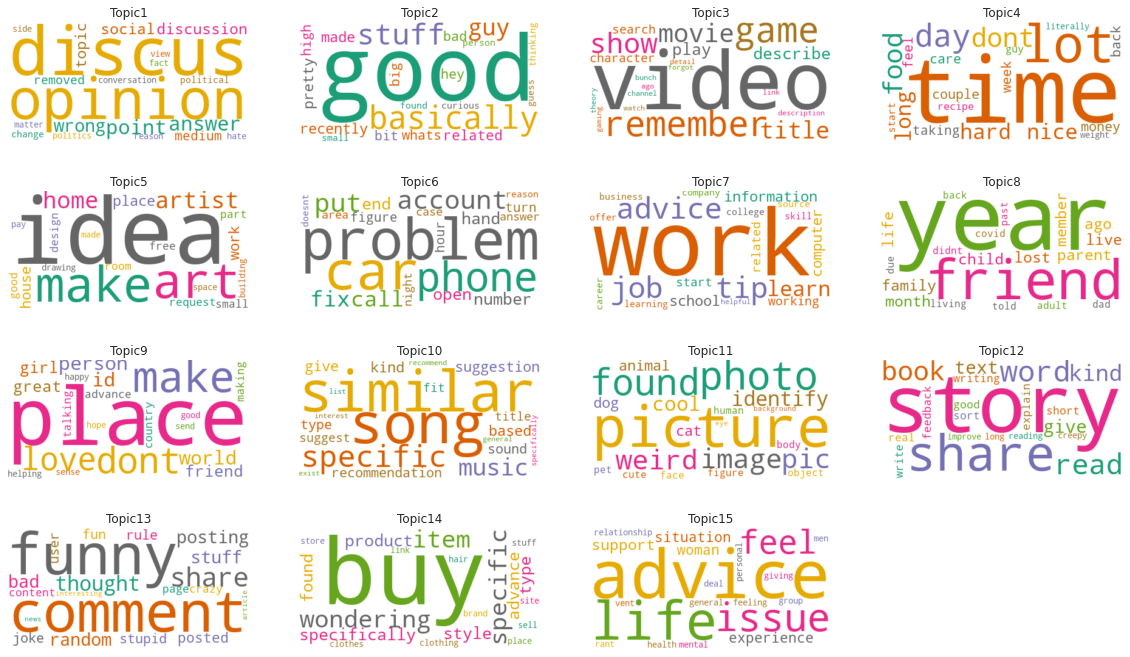

In [166]:
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(QA_lda_model.num_topics):
    wc.generate(text=topics_df["Terms per Topic"][i])
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])
plt.show()

In [167]:
# Convert Mallet Model for visualization
from gensim.models.ldamodel import LdaModel

def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

ldagensim = convertldaMalletToldaGen(QA_lda_model)

In [168]:
pyLDAvis.enable_notebook()
viz = gensimvis.prepare(ldagensim, df_QA_corpus, df_QA_id2word, sort_topics = False)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.110424  0.017199  1       1        6.797509
1     -0.134643 -0.060427  2       1        6.664226
2      0.064739  0.164271  3       1        6.434622
3      0.124536 -0.103587  4       1        6.940500
4     -0.181855 -0.202245  5       1        6.558551
5      0.139135 -0.012146  6       1        6.995559
6      0.089756 -0.089134  7       1        6.722071
7      0.156199 -0.113145  8       1        6.970599
8     -0.169403 -0.187660  9       1        6.686883
9     -0.033305  0.257592  10      1        6.446321
10     0.016972  0.105720  11      1        6.462034
11    -0.096416  0.076874  12      1        6.579753
12    -0.139550  0.053956  13      1        6.500093
13    -0.153319  0.128925  14      1        6.510157
14     0.206732 -0.036195  15      1        6.731121, topic_info=        Term         Freq        Total Category  logprob  loglift
266  video    2513.000000  2513.000000  Default  30.0000  30.0000
27   picture  2496.000000  2496.000000  Default  29.0000  29.0000
129  advice   3142.000000  3142.000000  Default  28.0000  28.0000
47   idea     2135.000000  2135.000000  Default  27.0000  27.0000
103  make     2865.000000  2865.000000  Default  26.0000  26.0000
..    ...             ...          ...      ...      ...      ...
302  feel     839.469918   1245.166838  Topic15 -3.4353   2.3042 
137  life     953.758334   1563.233578  Topic15 -3.3077   2.2043 
104  men      254.059012   328.855568   Topic15 -4.6305   2.4404 
259  rant     219.772482   270.381696   Topic15 -4.7755   2.4912 
60   general  455.968630   886.834305   Topic15 -4.0457   2.0332 

[719 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2504  15     0.986184  abuse  
1162  1      0.989064  accept 
2482  6      0.990469  access 
1247  2      0.002038  account
1247  6      0.960033  account
...  ..           ...      ...
42    1      0.973952  wrong  
42    4      0.023490  wrong  
1000  12     0.989897  wrote  
56    8      0.999178  year   
3027  8      0.994435  young  

[989 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

## 3. Pandas profiling report

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip  --quiet

In [ ]:
import pandas_profiling

df_QA['suggestions_flattened'] = df_QA.suggested_subreddits.apply(lambda x: ' '.join(map(str, x)))
pandas_profiling.ProfileReport(df_QA)

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]